In [1]:
import os
import torch
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from pathlib import Path
pd.set_option('display.max_columns', None)

In [2]:
source_list = ['/home/s175668/raid/Praca-Magisterska/csv_extracted/th_60_kp_with_conf/168_tomek_under_1.csv',
                '/home/s175668/raid/Praca-Magisterska/csv_extracted/th_60_kp_with_conf/411_tomek_under_0.csv',
                '/home/s175668/raid/Praca-Magisterska/csv_extracted/th_60_kp_with_conf/402_tomek_side_1.csv',
                '/home/s175668/raid/Praca-Magisterska/csv_extracted/th_60_kp_with_conf/410_tomek_side_0.csv',
                '/home/s175668/raid/Praca-Magisterska/csv_extracted/th_60_kp_with_conf/844_krystian_side_1.csv',
                '/home/s175668/raid/Praca-Magisterska/csv_extracted/th_60_kp_with_conf/833_krystian_side_0.csv',
                '/home/s175668/raid/Praca-Magisterska/csv_extracted/th_60_kp_with_conf/820_krystian_under_0.csv',
                '/home/s175668/raid/Praca-Magisterska/csv_extracted/th_60_kp_with_conf/824_krystian_under_1.csv',
                '/home/s175668/raid/Praca-Magisterska/csv_extracted/th_60_kp_with_conf/441_gustaw_under_0.csv',
                '/home/s175668/raid/Praca-Magisterska/csv_extracted/th_60_kp_with_conf/429_gustaw_under_1.csv',
                '/home/s175668/raid/Praca-Magisterska/csv_extracted/th_60_kp_with_conf/443_gustaw_side_0.csv',
                '/home/s175668/raid/Praca-Magisterska/csv_extracted/th_60_kp_with_conf/436_gustaw_side_1.csv',
                '/home/s175668/raid/Praca-Magisterska/csv_extracted/th_60_kp_with_conf/107_kuba_side_1.csv',
                '/home/s175668/raid/Praca-Magisterska/csv_extracted/th_60_kp_with_conf/109_kuba_side_0.csv',
                '/home/s175668/raid/Praca-Magisterska/csv_extracted/th_60_kp_with_conf/795_kuba_under_0.csv',
                '/home/s175668/raid/Praca-Magisterska/csv_extracted/th_60_kp_with_conf/642_kuba_under_1.csv']

In [3]:
markers = {
    0 : ['^', 'shoulder'], #shoulder trojkat
    1 : ['^', 'shoulder'], #shoulder trojkat
    2 : ['s', 'elbow'], #elbow kwadrat
    3 : ['s', 'elbow'], #elbow kwadrat
    4 : ['D', 'wrist'], #wrist
    5 : ['D', 'wrist'], #wrist
    6 : ['o', 'legs and nose'], 
    7 : ['o', 'legs and nose'], 
    8 : ['o', 'legs and nose'], 
    9 : ['o', 'legs and nose'], 
    10 : ['o', 'legs and nose'], 
    11 : ['o', 'legs and nose'], 
    12 : ['o', 'legs and nose'], 
    13 : ['o', 'legs and nose'], 
}
colors = {
    0: 'red',
    1: 'black'
}
parts = ['LShoulder', 'RShoulder', 'LElbow', 'RElbow', 'LWrist', 'RWrist', 'LHips', 'RHips', 'LKnee',
         'RKnee', 'LAnkle', 'RAnkle']

In [4]:
def create_new_cordinate_space(x, y, frame):
        lh_x, rh_x = x[frame,6], x[frame,7]
        lh_y, rh_y = y[frame,6], y[frame,7]
        x0, y0 = abs(lh_x - rh_x)/2, abs(lh_y - rh_y)/2
        x0 += min(lh_x, rh_x)
        y0 += min(lh_y, rh_y)
        
        return x0, y0
    

In [5]:
def interpolation(cords):
    index = np.where(cords == 0)
    for c in range(cords.shape[1]):
        cords_to_interp = cords[:, c]

        timestep = np.where(cords_to_interp > 0)[0]
        index_to_interp = np.where(cords_to_interp == 0)[0]
        cords_to_interp = np.delete(cords_to_interp, index_to_interp)
        
        interpolated = np.interp(index_to_interp, timestep, cords_to_interp)
        
        for i, index in enumerate(index_to_interp):
            cords[index, c] = interpolated[i]
        
    return cords

In [6]:
def calulate_vector_length(cords_x, cords_y, nose_x, nose_y, first_frame=False):
    vector_lenth = np.zeros((14,12))
    for t in range(14):
        for kp in range(12):
            x1, y1 = cords_x[t, kp], cords_y[t,kp]
            vector_lenth[t, kp] = math.sqrt((x1-x0)**2+(y1-y0)**2)
    
    return vector_lenth

In [7]:
def data_load(csv_path):

    df = pd.read_csv(csv_path)
    df = df.reset_index(drop=True)

    target = df.iloc[0,-1]
    conf = df.iloc[:, 4:-1:3].values
    df = df.drop(df.columns[[i for i in range(4, 39, 3)]], axis = 1)
    df = df.drop(['TARGET'], axis=1)
    cords = df.iloc[:, :].values

    conf = interpolation(conf)
    cords = interpolation(cords)

    nose_x, nose_y = cords[:, 0], cords[:, 1]
    cords_x, cords_y = cords[:, 2::2], cords[:, 3::2]

#     lh_x, rh_x = cords_x[0,6], cords_x[0,7]
#     lh_y, rh_y = cords_y[0,6], cords_y[0,7]
#     x0, y0 = abs(lh_x - rh_x)/2, abs(lh_y - rh_y)/2

#     normalize_vector = math.sqrt((nose_x[0]-x0)**2+(nose_y[0]-y0)**2)
#     vector_length = calulate_vector_length(cords_x, cords_y, x0, y0) / normalize_vector
    
    return cords_x, cords_y, nose_x, nose_y, df
    

In [8]:
def plot_keypoints_relative_to_00(files, frame_n, first_frame=False, normalize=False):
    for file_n, file in enumerate(files):
        cords_x, cords_y, nose_x, nose_y, _ = data_load(file)

        for i in range(cords_x.shape[0]):
            if first_frame and i<1:
                x0, y0 = create_new_cordinate_space(cords_x, cords_y, 0)
                z = 0
            elif not first_frame: 
                x0, y0 = create_new_cordinate_space(cords_x, cords_y, i)
                z = i

            cords_x[i], cords_y[i] = cords_x[i]-x0, cords_y[i]-y0

            if normalize:
                normalize_vector = math.sqrt((nose_x[z]-x0)**2+(nose_y[z]-y0)**2)
                cords_x[i], cords_y[i] = cords_x[i] / normalize_vector, cords_y[i] / normalize_vector
                    
        for i in range(cords_x.shape[1]): 
            plt.plot(cords_x[frame_n, i], cords_y[frame_n, i]*-1, markers[i][0], color=colors[file_n], label = markers[i][1] if ((i<7) and (i%2==0) and file_n==0) else None )
    plt.legend(loc=(1.04, 0))
    plt.show()
    

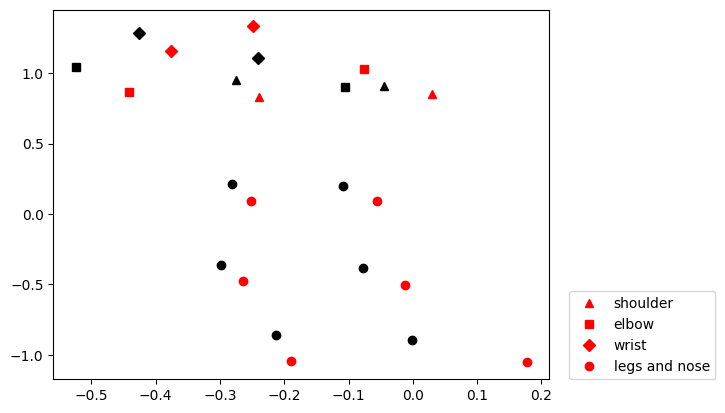

In [20]:
plot_keypoints_relative_to_00([source_list[4], source_list[-4]], 8, True, True)

In [47]:
def plot_signals(files, first_frame=False, normalize=False):
    fig, axs = plt.subplots(6, 2, figsize=(18, 18))
    fig.tight_layout(pad=4.0)
    axs = axs.flatten()
    z = 0
    
    for part_id, part in enumerate(parts):
        for file_n, file in enumerate(files):
            cords_x, cords_y, nose_x, nose_y, _ = data_load(file)
            
            for i in range(cords_x.shape[0]):
           
                if first_frame and i<1:
                    x0, y0 = create_new_cordinate_space(cords_x, cords_y, 0)
                    z = 0
                elif not first_frame: 
                    x0, y0 = create_new_cordinate_space(cords_x, cords_y, i)
                    z = i

                cords_x[i], cords_y[i] = cords_x[i]-x0, cords_y[i]-y0
                
                if normalize:
                    normalize_vector = math.sqrt((nose_x[z]-x0)**2+(nose_y[z]-y0)**2)
                    cords_x[i], cords_y[i] = cords_x[i] / normalize_vector, cords_y[i] / normalize_vector
                    
            timestep = [i for i in range(cords_x.shape[0])]
            
            axs[part_id].plot(timestep, cords_x[:, part_id], color=colors[file_n], linewidth = 3)
        
            axs[part_id].plot(timestep, cords_y[:, part_id]*-1, color=colors[file_n], linewidth = 3, marker='o')
        
            axs[part_id].set_xlabel('timestep')
            axs[part_id].set_ylabel('values')
            
        axs[part_id].set_title(part)
        axs[part_id].imshow
        

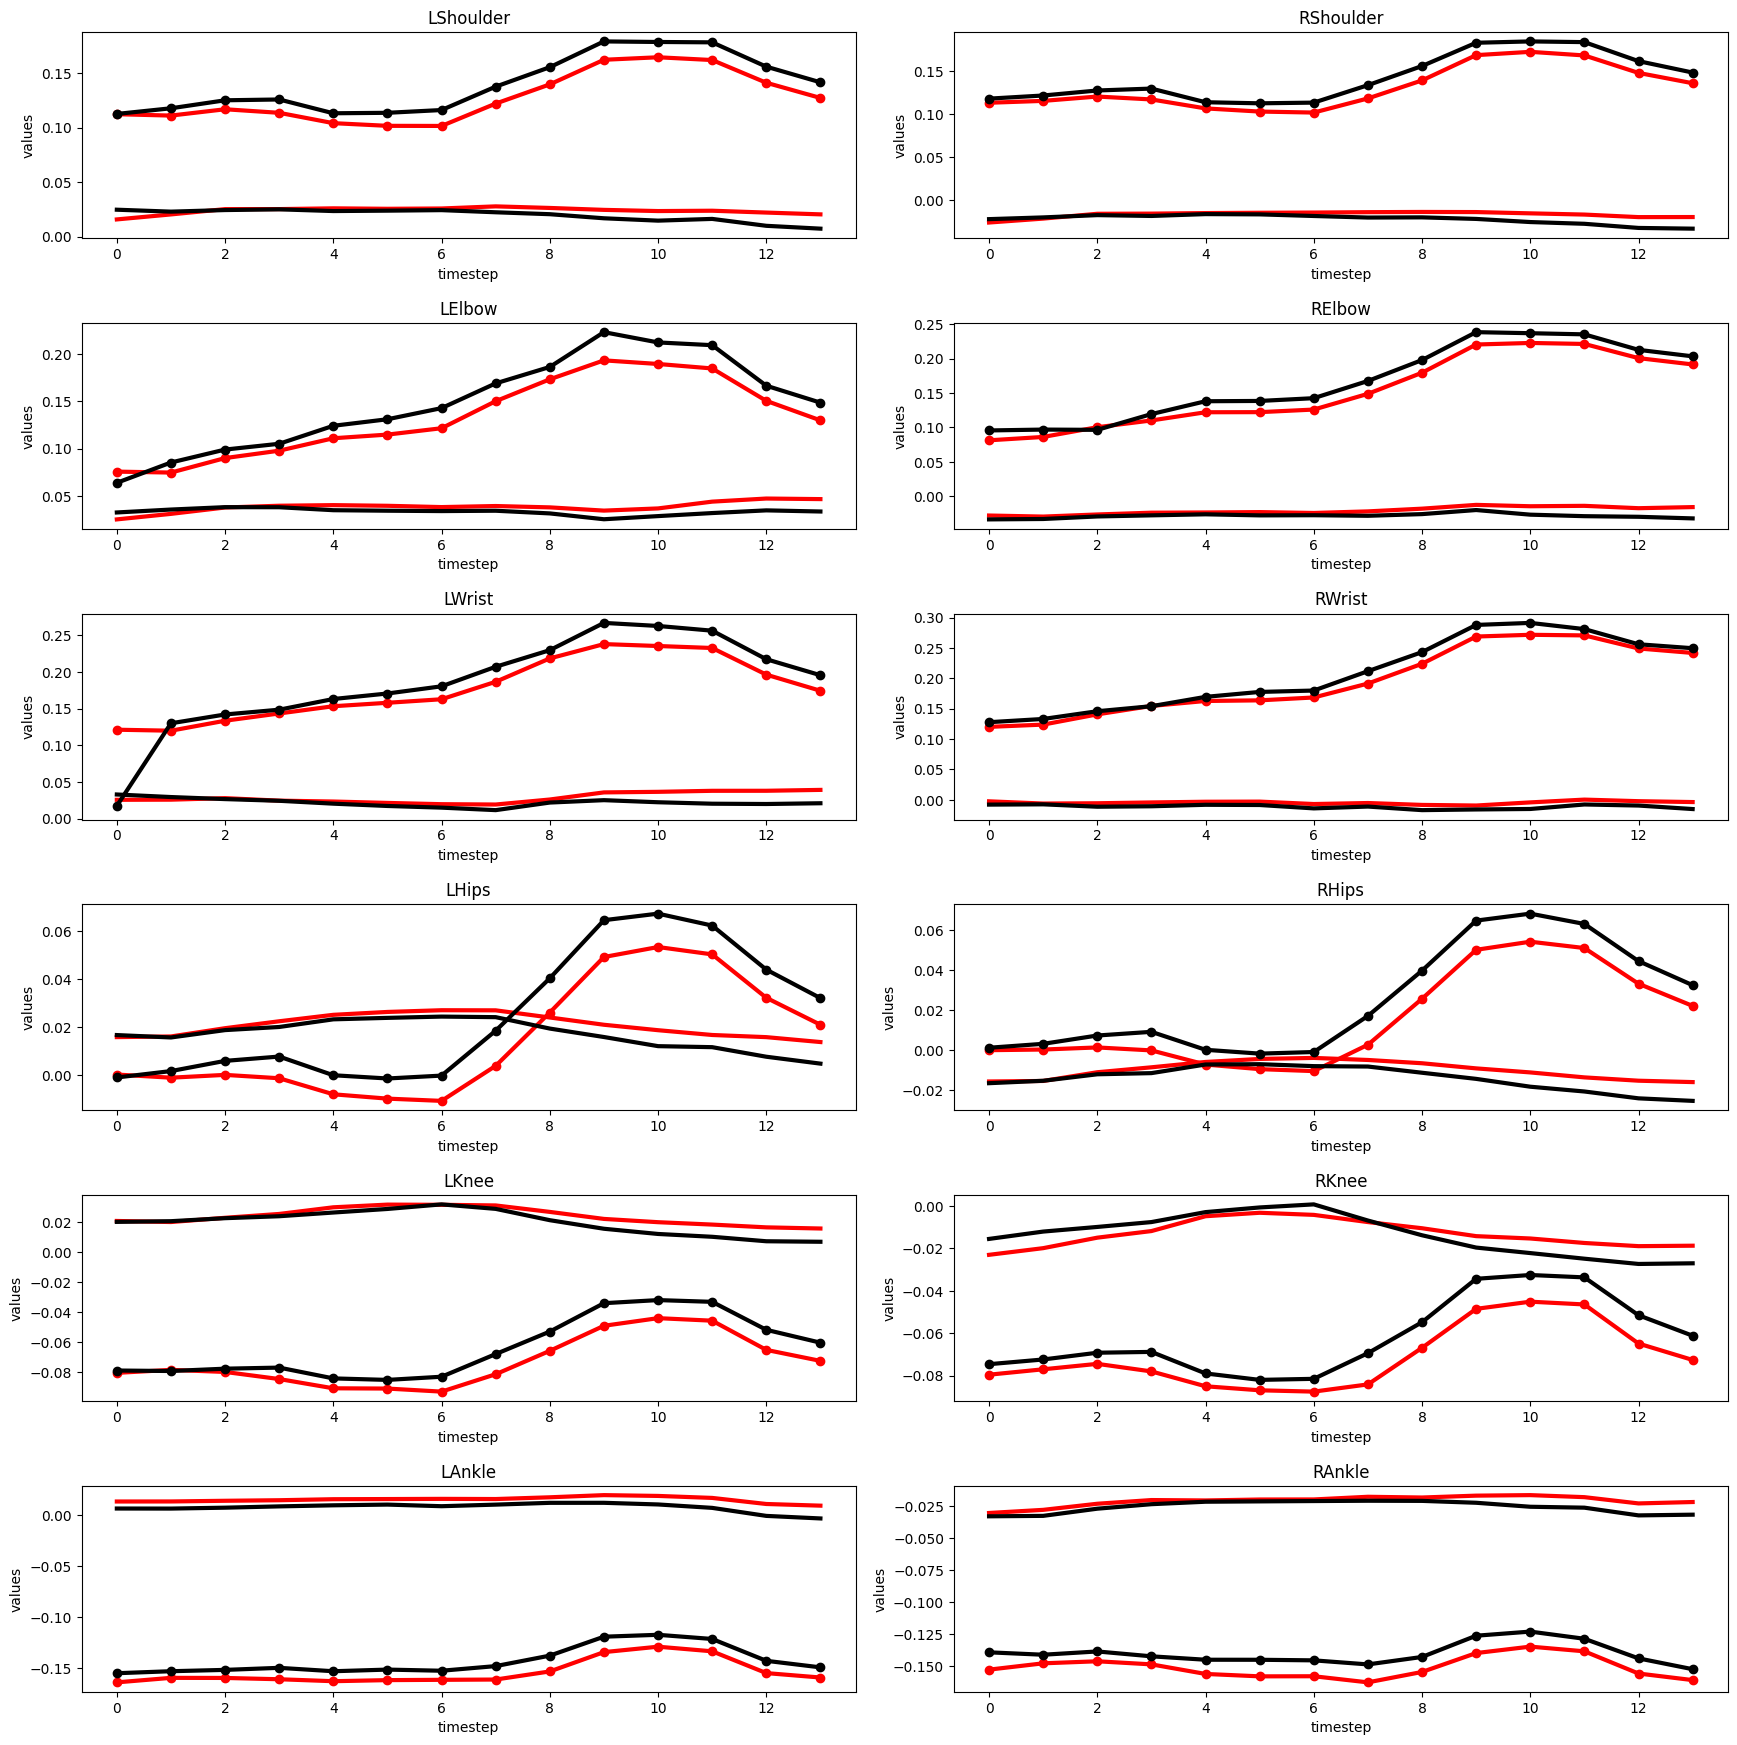

In [48]:
plot_signals(source_list[8:10], first_frame=True, normalize=False)

In [15]:
df = pd.read_csv(source_list[4])

In [16]:
df

,NOSE_X,NOSE_Y,LEFT_SHOULDER_X,LEFT_SHOULDER_Y,CONF,RIGH_SHOULDER_X,RIGH_SHOULDER_Y,CONF.1,LEFT_ELBOW_X,LEFT_ELBOW_Y,CONF.2,RIGHT_ELBOW_X,RIGHT_ELBOW_Y,CONF.3,LEFT_WRIST_X,LEFT_WRIST_Y,CONF.4,RIGHT_WRIST_X,RIGHT_WRIST_Y,CONF.5,LEFT_HIPS_X,LEFT_HIPS_Y,CONF.6,RIGHT_HIPS_X,RIGHT_HIPS_Y,CONF.7,LEFT_KNEE_X,LEFT_KNEE_Y,CONF.8,RIGHT_KNEE_X,RIGHT_KNEE_Y,CONF.9,LEFT_ANKLE_X,LEFT_ANKLE_Y,CONF.10,RIGHT_ANKLE_X,RIGHT_ANKLE_Y,CONF.11,TARGET
0,0.797763,0.611134,0.841239,0.652714,0.974668,0.796570,0.658086,0.956942,0.854042,0.721464,0.951054,0.804406,0.718550,0.820350,0.818987,0.762954,0.930333,0.796326,0.761426,0.794112,0.852503,0.773330,0.980005,0.817812,0.775065,0.973270,0.861152,0.869482,0.968941,0.799238,0.856182,0.954246,0.877863,0.971897,0.932479,0.822702,0.943929,0.915096,1
1,0.797725,0.611371,0.840702,0.652924,0.974423,0.796138,0.657493,0.957544,0.853566,0.722125,0.949715,0.805107,0.716706,0.823840,0.819925,0.763409,0.928801,0.798602,0.753916,0.797383,0.852475,0.771419,0.979623,0.817702,0.772891,0.973157,0.860772,0.869488,0.967518,0.798272,0.854900,0.952904,0.878001,0.972185,0.927735,0.820170,0.944940,0.910234,1
2,0.796995,0.611911,0.839886,0.656188,0.975993,0.794272,0.659665,0.963836,0.851159,0.725815,0.952702,0.802072,0.720267,0.862786,0.818617,0.769331,0.935522,0.794815,0.760161,0.843806,0.849680,0.773962,0.980538,0.815031,0.775530,0.975751,0.858352,0.870016,0.968075,0.800221,0.861152,0.956778,0.877551,0.971722,0.927789,0.814649,0.958986,0.913859,1
3,0.796759,0.614325,0.838497,0.661190,0.977277,0.791929,0.663070,0.967934,0.844759,0.730872,0.957029,0.796768,0.723467,0.884863,0.810934,0.773739,0.943499,0.786041,0.761963,0.871192,0.847749,0.776805,0.981218,0.813574,0.778753,0.977384,0.851010,0.871168,0.969319,0.800222,0.869049,0.959461,0.875530,0.971596,0.929787,0.816086,0.962934,0.917092,1
4,0.804323,0.619672,0.839316,0.667260,0.982696,0.791482,0.671758,0.975199,0.828624,0.724212,0.962562,0.788886,0.727771,0.879906,0.785802,0.736834,0.948260,0.765490,0.739601,0.858793,0.841954,0.784173,0.982046,0.808259,0.786852,0.977935,0.835817,0.877941,0.970080,0.791619,0.877316,0.957839,0.872431,0.969633,0.931187,0.815384,0.963602,0.914811,1
5,0.807603,0.624917,0.842908,0.670554,0.981762,0.794311,0.675471,0.976419,0.821806,0.704813,0.962930,0.779396,0.725794,0.903088,0.781468,0.698549,0.950422,0.761328,0.706137,0.888044,0.837955,0.792697,0.983595,0.804663,0.794119,0.980784,0.828107,0.882845,0.973828,0.785119,0.880444,0.964821,0.870137,0.968638,0.943160,0.811601,0.963586,0.931575,1
6,0.808033,0.627251,0.841157,0.669692,0.977362,0.797780,0.675064,0.969977,0.817368,0.679803,0.967597,0.767370,0.707677,0.915862,0.787163,0.657337,0.958286,0.754674,0.663401,0.906331,0.832619,0.795970,0.988982,0.800077,0.797554,0.986780,0.823779,0.884390,0.983425,0.782126,0.882476,0.976491,0.868841,0.967277,0.958830,0.809243,0.960956,0.946729,1
7,0.818141,0.612820,0.841766,0.652518,0.974156,0.798023,0.654284,0.970531,0.820448,0.627841,0.958564,0.764082,0.657473,0.926358,0.786688,0.587296,0.947443,0.766837,0.605852,0.916260,0.828130,0.778656,0.985341,0.796530,0.778093,0.983775,0.828749,0.877140,0.975287,0.785776,0.871937,0.970103,0.869732,0.967510,0.945422,0.806863,0.957417,0.938516,1
8,0.810440,0.598091,0.840267,0.631417,0.972152,0.795174,0.635479,0.966922,0.822512,0.601404,0.958940,0.761398,0.629530,0.923061,0.793616,0.551317,0.947366,0.772164,0.580857,0.912387,0.825948,0.759163,0.985208,0.793011,0.759142,0.983341,0.833081,0.858564,0.973996,0.791020,0.853740,0.968583,0.864814,0.950720,0.941923,0.803487,0.949306,0.934648,1
9,0.806456,0.564579,0.836160,0.605849,0.970807,0.792193,0.606926,0.966385,0.822205,0.562211,0.957244,0.758671,0.583281,0.922064,0.795919,0.509846,0.948228,0.772410,0.532999,0.914429,0.825033,0.732461,0.985076,0.793133,0.732072,0.983519,0.827188,0.838076,0.973735,0.792404,0.835174,0.968708,0.851208,0.942422,0.939401,0.801263,0.931397,0.932694,1
